In [23]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [12]:
# =============================================================================
# DATA PREPARATION
# =============================================================================

# Load your dataset (replace with your actual data loading)
dataset = pd.read_csv('ibm_hr_cleaned.csv', index_col=False)
dataset.shape # > 1470 x 32

(1470, 32)

In [13]:

 # =============================================================================
# DATA PREPARATION
# =============================================================================
# Separate numerical and categorical columns
numeric_cols = ['age', 'totalworkingyears', \
                'joblevel', 'education', 'numcompaniesworked'
]
categorical_cols = ['overtime', 'department', 'educationfield', \
                    'businesstravel', 'gender'
]
X = dataset[numeric_cols + categorical_cols]
# Prepare X (features) and y (target)
y = dataset['monthlyincome'] 

In [15]:
# =============================================================================
# TRAIN-TEST SPLIT
# =============================================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=True
) # split 3:7

print(f"\nTraining set: {X_train.shape}") # > (1029, 10)
print(f"Testing set: {X_test.shape}")     # > (441, 10)


Training set: (1029, 10)
Testing set: (441, 10)


(1029,)

In [18]:
# =============================================================================
# BASIC OLS MODEL CONSTRUCTION
# =============================================================================
# Create the OLS formula
# For numeric variables: use as-is
# For categorical variables: wrap with C() to treat as categorical
numeric_terms = " + ".join(numeric_cols)
categorical_terms = " + ".join([f"C({col})" for col in categorical_cols])

ols_formula = f"{target} ~ {numeric_terms} + {categorical_terms}"


In [35]:
# =============================================================================
# OLS MODEL CHANGING THE REFERENCE LEVEL
# =============================================================================
# I did an EDA in tableau and found that people from the Sales department earn the highest, education field as Marketing earn the highest 
# and people who travel rarely earn the highest
# I want to change the model to see how it performs
# Create the OLS formula with custom reference levels
numeric_terms = " + ".join(numeric_cols)

# For categorical variables with custom reference levels
categorical_terms = [
    "C(overtime)",  # Keep original (No as reference)
    "C(department, Treatment(reference='Sales'))",  # Sales as reference
    "C(educationfield, Treatment(reference='Marketing'))",  # Marketing as reference
    "C(businesstravel, Treatment(reference='Travel_Rarely'))",  # Travel_Rarely as reference
    "C(gender)",  # Keep original (Female as reference)
    # Add other categorical variables without custom references
] + [f"C({col})" for col in categorical_cols if col not in ['department', 'educationfield', 'businesstravel', 'overtime', 'gender']]

categorical_formula = " + ".join(categorical_terms)

ols_formula = f"{target} ~ {numeric_terms} + {categorical_formula}"


In [36]:
# Create OLS dataframe by combining X_train and y_train
ols_data = pd.concat([X_train, y_train], axis=1)
# =============================================================================
# MODEL FITTING
# =============================================================================

# Create OLS object and fit the model
OLS = ols(formula=ols_formula, data=ols_data)
model = OLS.fit()

In [37]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          monthlyincome   R-squared:                       0.912
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     653.8
Date:                Thu, 20 Nov 2025   Prob (F-statistic):               0.00
Time:                        18:20:59   Log-Likelihood:                -8931.4
No. Observations:                1029   AIC:                         1.790e+04
Df Residuals:                    1012   BIC:                         1.798e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                                                                   coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [38]:
# =============================================================================
# MODEL DIAGNOSTICS
# =============================================================================

# Get predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Calculate R-squared for test set manually
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

test_r2 = r2_score(y_test, y_pred_test)
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)

print(f"\nTEST SET PERFORMANCE:")
print(f"R² Score: {test_r2:.4f}")
print(f"RMSE: {test_rmse:.2f}")
print(f"MAE: {test_mae:.2f}")


TEST SET PERFORMANCE:
R² Score: 0.8933
RMSE: 1469.16
MAE: 1133.61


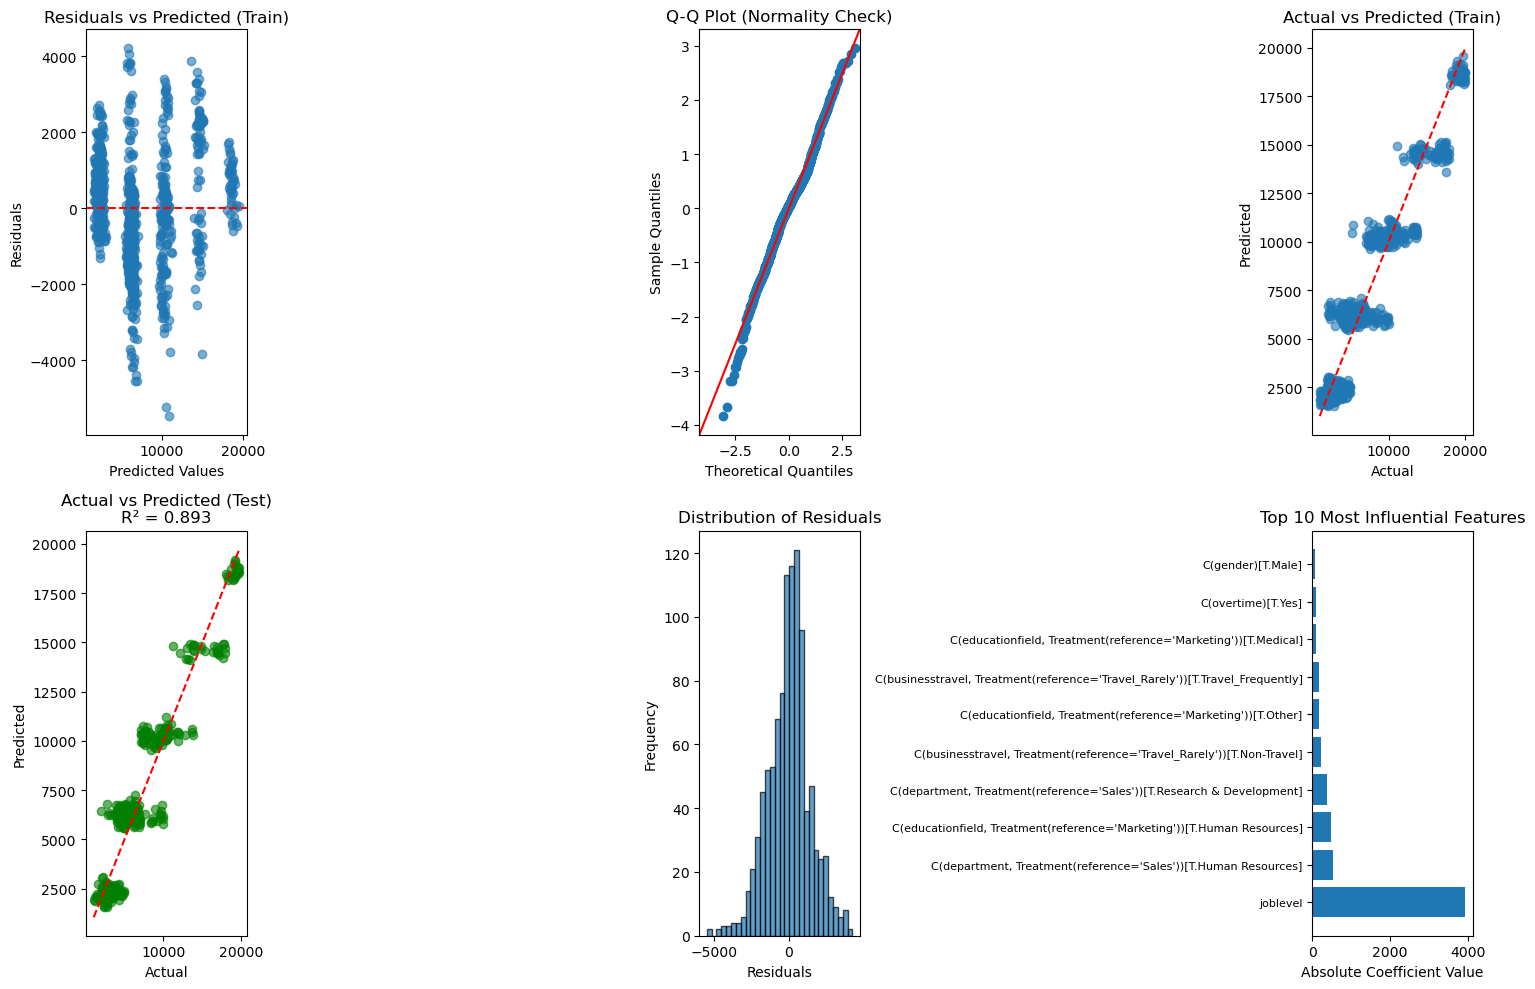

In [39]:
# =============================================================================
# RESIDUAL ANALYSIS
# =============================================================================

# Calculate residuals
residuals_train = y_train - y_pred_train
residuals_test = y_test - y_pred_test

# Create diagnostic plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. Residuals vs Predicted values
axes[0, 0].scatter(y_pred_train, residuals_train, alpha=0.6)
axes[0, 0].axhline(y=0, color='red', linestyle='--')
axes[0, 0].set_xlabel('Predicted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Predicted (Train)')

# 2. Q-Q plot for normality
sm.qqplot(residuals_train, line='45', fit=True, ax=axes[0, 1])
axes[0, 1].set_title('Q-Q Plot (Normality Check)')

# 3. Actual vs Predicted
axes[0, 2].scatter(y_train, y_pred_train, alpha=0.6)
axes[0, 2].plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'red', linestyle='--')
axes[0, 2].set_xlabel('Actual')
axes[0, 2].set_ylabel('Predicted')
axes[0, 2].set_title('Actual vs Predicted (Train)')

# 4. Test set: Actual vs Predicted
axes[1, 0].scatter(y_test, y_pred_test, alpha=0.6, color='green')
axes[1, 0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'red', linestyle='--')
axes[1, 0].set_xlabel('Actual')
axes[1, 0].set_ylabel('Predicted')
axes[1, 0].set_title(f'Actual vs Predicted (Test)\nR² = {test_r2:.3f}')

# 5. Distribution of residuals
axes[1, 1].hist(residuals_train, bins=30, alpha=0.7, edgecolor='black')
axes[1, 1].set_xlabel('Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Residuals')

# 6. Feature importance (top 10 coefficients)
coefficients = model.params.drop('Intercept')
top_10_coef = coefficients.abs().nlargest(10)
axes[1, 2].barh(range(len(top_10_coef)), top_10_coef.values)
axes[1, 2].set_yticks(range(len(top_10_coef)))
axes[1, 2].set_yticklabels(top_10_coef.index, fontsize=8)
axes[1, 2].set_xlabel('Absolute Coefficient Value')
axes[1, 2].set_title('Top 10 Most Influential Features')

plt.tight_layout()
plt.show()

In [40]:
# features that have p-value < 0.05
significant_features = model.pvalues[model.pvalues < 0.05].sort_values()
print(f"\nSignificant features (p < 0.05): {len(significant_features)}")



Significant features (p < 0.05): 4


In [41]:
print("\nStatistically significant features:")
for feature, pval in significant_features.items():
    coef = model.params[feature]
    print(f"  - {feature}: coef = {coef:8.2f}, p-value = {pval:.4f}")


Statistically significant features:
  - joblevel: coef =  3929.57, p-value = 0.0000
  - Intercept: coef = -2021.44, p-value = 0.0000
  - C(department, Treatment(reference='Sales'))[T.Research & Development]: coef =   369.61, p-value = 0.0018
  - totalworkingyears: coef =    33.17, p-value = 0.0029


In [42]:
print(f"\nCategorical Variable Reference Levels:")
for cat_var in categorical_cols:
    # Get the coefficients for this categorical variable
    cat_coefs = model.params[model.params.index.str.contains(cat_var)]
    if len(cat_coefs) > 0:
        print(f"\n{cat_var}:")
        # The first level is the reference (omitted), others are relative to it
        for level, coef in cat_coefs.items():
            level_name = level.replace(f"C({cat_var})[T.", "").replace("]", "")
            print(f"    - {level_name}: {coef:.2f} (relative to reference level)")


Categorical Variable Reference Levels:

overtime:
    - Yes: 83.87 (relative to reference level)

department:
    - C(department, Treatment(reference='Sales'))[T.Human Resources: 523.09 (relative to reference level)
    - C(department, Treatment(reference='Sales'))[T.Research & Development: 369.61 (relative to reference level)

educationfield:
    - C(educationfield, Treatment(reference='Marketing'))[T.Human Resources: 475.30 (relative to reference level)
    - C(educationfield, Treatment(reference='Marketing'))[T.Life Sciences: -15.92 (relative to reference level)
    - C(educationfield, Treatment(reference='Marketing'))[T.Medical: 91.89 (relative to reference level)
    - C(educationfield, Treatment(reference='Marketing'))[T.Other: -169.73 (relative to reference level)
    - C(educationfield, Treatment(reference='Marketing'))[T.Technical Degree: 13.21 (relative to reference level)

businesstravel:
    - C(businesstravel, Treatment(reference='Travel_Rarely'))[T.Non-Travel: -209.74 (r